# Analysis notebook for CAB (with a focus on stimulus design/piloting)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import pymongo as pm
import os, sys

In [2]:
# display all columns
pd.set_option('display.max_columns', None)

## Create folders to save out results

In [3]:
## create relevant project subdirs
proj_dir = os.path.abspath('..')
analysis_dir =  os.path.join(proj_dir,'analysis')
results_dir = os.path.join(proj_dir,'results')
csv_dir = os.path.join(results_dir,'csv')
plots_dir = os.path.join(results_dir,'plots')

def makedir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return

In [4]:
print("The project directory is: {}".format(proj_dir))

The project directory is: /Users/felixbinder/Cloud/Grad School/Fan Lab/BACH/cognitive-ai-benchmarking


In [5]:
makedir(results_dir)
makedir(csv_dir)
makedir(plots_dir)

In [6]:
# we need to get to the repo level to import cabutils
sys.path.append(proj_dir)
sys.path.append(os.path.join(proj_dir,'stimuli'))
import cabutils
from stimuli.experiment_config import *

## Experiment parameters

In [7]:
PROJECT = "Physion_V1_5" 
DATASET = "Dominoes"
TASK = "OCP"
ITERATION = "pilot_1"
EXPERIMENT = DATASET + "_" + TASK

## Load data from database

In [9]:
!ssh -fNL 27017:127.0.0.1:27017 fbinder@cogtoolslab.org

fbinder@cogtoolslab.org's password: 


In [10]:
# this will create the database connection
from analysis.generate_dataframes import * 

Checking database connection...
Connected to database.


In [12]:
df, df_familiarization = pull_dataframes_from_mongo(PROJECT, DATASET, TASK, ITERATION, anonymizeIDs=False)

Reading from Physion_V1_5_output.Dominoes_OCP and Physion_V1_5_input.Dominoes_OCP
Reading iteration pilot_1
This might take a while...
Got 3479 rows from the database


100%|██████████| 38/38 [00:00<00:00, 311.07it/s]


Filled 10 Prolific IDs from manually recorded ones


100%|██████████| 38/38 [00:00<00:00, 1562.81it/s]


97.5th percentile for streak length is 1000.
There are 0 flagged IDs so far due to long streaks.
There are 0 flagged IDs so far due to alternating sequences.
Familiarization dataframe provided in D.
Familiarization dataframe has 72 rows.
Not all prolific IDs are covered in familiarization data. Make sure you pass familiarization data for all trials!
There are 17 flagged IDs due to failing the familiarization trials
There are 0 flagged IDs so far due to low accuracy.
There are 2 flagged IDs so far due to high RTs.
There are a total of 2 flagged IDs.
There are a total of 36 valid and complete sessions for Dominoes.


# Analysis

## Overall correctness

In [13]:
# get percentage of correct trials
df['correct'].value_counts() / len(df) * 100

True     83.397897
False    16.602103
Name: correct, dtype: float64

### Overall correctness by stimulus

In [14]:
df.groupby('stim_ID')['correct'].mean()

stim_ID
pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0000    0.857143
pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0001    0.785714
pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0002    0.833333
pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0004    0.923077
pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0005    0.916667
                                                        ...   
pilot_dominoes_default_boxroom_0014                   0.818182
pilot_dominoes_default_boxroom_0015                   0.750000
pilot_dominoes_default_boxroom_0022                   0.916667
pilot_dominoes_default_boxroom_0023                   0.833333
pilot_dominoes_default_boxroom_0025                   1.000000
Name: correct, Length: 158, dtype: float64

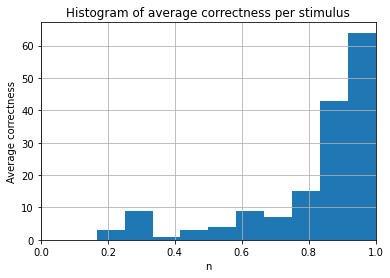

In [15]:
# histogram of avg correctness per stim
df.groupby('stim_ID')['correct'].mean().hist()
plt.title('Histogram of average correctness per stimulus')
plt.xlabel('n')
plt.ylabel('Average correctness')
plt.xlim(0,1)
plt.show()

### Overall correctness by participant

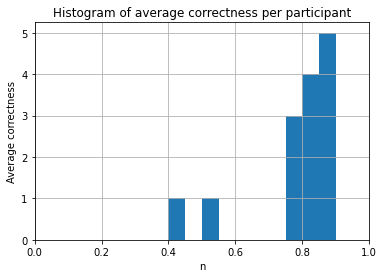

In [16]:
# histogram of avg correctness per gameID
df.groupby('gameID')['correct'].mean().hist()
plt.title('Histogram of average correctness per participant')
plt.xlabel('n')
plt.ylabel('Average correctness')
plt.xlim(0,1)
plt.show()

## Reliability

In [17]:
# import correlation metrics
from scipy.stats import pearsonr, spearmanr

In [18]:
ITERATIONS = 10000 # how many iterations to do **per n**
METRIC = lambda x,y: pearsonr(x,y)[0] # what metric to use for correlation

### Split half correlation over distinct halfs
This can only go up to n/2, where n is the number of trials.  

In [19]:
correlations = {}
for n in tqdm(range(1,df['gameID'].nunique()//2)):
    correlations[n] = []
    for i in range(ITERATIONS):
        # sample n participants into two exclusive groups
        sample = df['gameID'].sample(n=n*2,replace=False)
        group1 = sample.iloc[:n]
        group2 = sample.iloc[n:]
        # get the correlation over average correctness per stimulus
        vec1 = df[df['gameID'].isin(group1)].groupby('stim_ID')['correct'].mean()
        vec2 = df[df['gameID'].isin(group2)].groupby('stim_ID')['correct'].mean()
        # possibly the groups contain different stimuli—drop the ones that don't overlap
        singular_stims = set(vec1.index).symmetric_difference(set(vec2.index))
        for sing in singular_stims:
            try: 
                vec1 = vec1.drop(sing)
            except: pass
            try:
                vec2 = vec2.drop(sing)
            except: pass
        assert np.all(list(vec1.index) == list(vec2.index))
        correlations[n].append(METRIC(vec1.values,vec2.values))

  0%|          | 0/6 [00:00<?, ?it/s]/Users/felixbinder/opt/anaconda3/envs/curiophysion/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████| 6/6 [17:08<00:00, 171.49s/it]


Text(0.5, 0, 'n Participants')

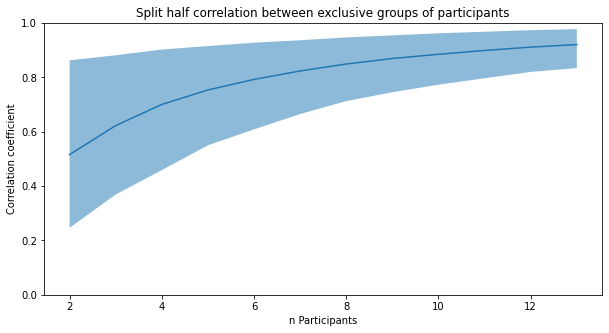

In [29]:
# plot
plt.figure(figsize=(10,5))
plt.plot(list(correlations.keys()),[np.mean(correlations[n]) for n in correlations.keys()],label='mean')
plt.fill_between(list(correlations.keys()),[np.percentile(correlations[n],2.5) for n in correlations.keys()],
                    [np.percentile(correlations[n],97.5) for n in correlations.keys()],alpha=0.5,label='95% CI')
plt.title('Split half correlation between exclusive groups of participants')
plt.ylabel('Correlation coefficient')
plt.ylim(0,1)
plt.xlabel('n Participants')

### Bootstrapped split half correlation
Bootstrapping over participants. 

In [21]:
correlations = {}
for n in tqdm(range(1,df['gameID'].nunique())):
    correlations[n] = []
    for i in range(ITERATIONS):
        # sample n participants into two exclusive groups
        group1 = df['gameID'].sample(n=n,replace=False)
        group2 = df['gameID'].sample(n=n,replace=False)
        # get the correlation over average correctness per stimulus
        vec1 = df[df['gameID'].isin(group1)].groupby('stim_ID')['correct'].mean()
        vec2 = df[df['gameID'].isin(group2)].groupby('stim_ID')['correct'].mean()
        # possibly the groups contain different stimuli—drop the ones that don't overlap
        singular_stims = set(vec1.index).symmetric_difference(set(vec2.index))
        for sing in singular_stims:
            try: 
                vec1 = vec1.drop(sing)
            except: pass
            try:
                vec2 = vec2.drop(sing)
            except: pass
        assert np.all(list(vec1.index) == list(vec2.index))
        correlations[n].append(METRIC(vec1.values,vec2.values))

100%|██████████| 13/13 [37:49<00:00, 174.57s/it]


Text(0.5, 0, 'n Participants')

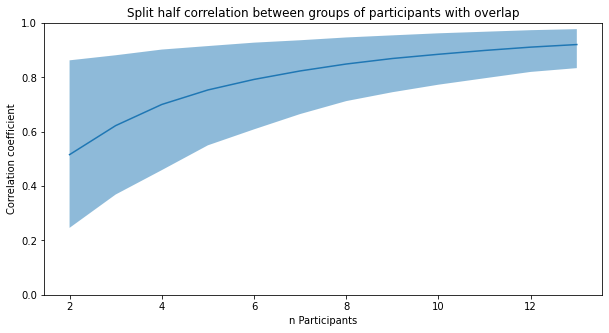

In [30]:
# plot
plt.figure(figsize=(10,5))
plt.plot(list(correlations.keys()),[np.mean(correlations[n]) for n in correlations.keys()],label='mean')
plt.fill_between(list(correlations.keys()),[np.percentile(correlations[n],2.5) for n in correlations.keys()],
                    [np.percentile(correlations[n],97.5) for n in correlations.keys()],alpha=0.5,label='95% CI')
plt.title('Split half correlation between groups of participants with overlap')
plt.ylabel('Correlation coefficient')
plt.ylim(0,1)
plt.xlabel('n Participants')

## Stimuli

Let's have an overview over all the stimuli

In [23]:
df.groupby('stim_ID').agg({'correct':['mean','std'], 'target_hit_zone_label':'first'}).style.background_gradient(cmap='Oranges', vmin=0, vmax=1)

### The most extreme stimuli

In [24]:
DISPLAY_N = 5

In [25]:
from IPython.display import HTML

def display_rows(_df):
    """Expects a dataframe with the colums 'stimulus_name', 'response', 'stim_url'. 
    Needs to be wrapped in HTML() to display in a notebook"""
    html = ""
    for i,row in _df.iterrows():
        div = """
<div>
<b>Stim name</b>: {}<br>
<b>Predicted positive</b>: {}<br>
<b>True Outcome</b>:       {}<br>
<video width="40%" controls>
<source src="{}">
</video></div>""".format(row['stim_ID'],row['responseBool'],row['target_hit_zone_label'],row['mp4s_url'])
        html+=div
    return html

In [26]:
# get the DISPLAY_N rows with the highest correctness
most_correct = df.groupby('stim_ID').agg({'correct':'mean', 'responseBool':'mean', 'mp4s_url':'first', 'target_hit_zone_label':'first'}).sort_values('correct',ascending=False).head(DISPLAY_N).reset_index()
least_correct = df.groupby('stim_ID').agg({'correct':'mean', 'responseBool':'mean', 'mp4s_url':'first', 'target_hit_zone_label':'first'}).sort_values('correct',ascending=True).head(DISPLAY_N).reset_index()

The **most correct** stimuli

In [27]:
HTML(display_rows(most_correct))

The **least correct** stimuli

In [28]:
HTML(display_rows(least_correct))